# Task 2: 量子模拟器实现

In [1]:
# 实现的两个包
from circuit import Circuit, CNOT, U3  #

import time
from numpy import pi
import numpy as np

## 初始化电路

In [2]:
qubit_numer = 2
qc = Circuit(qubit_numer) # 有两个比特[0,1]

### 电路提供了两种门 CNOT门 和 U3 门。

1. U3 是一个单比特门, 除了连接的比特，有三个参数 theta、lambda、phi。
2. CNOT 是一个两比特门， 除了连接的两个比特，没有参数

In [3]:
u3 = U3(0, pi/2, pi/3, pi/4)  # 参数：作用的比特位置，theta、lambda、phi
qc.addGate(u3)  # 将其加入电路中
u3.matrix()  # 一个u3门对应一个2X2的矩阵

array([[ 0.70710678+0.j        , -0.35355339-0.61237244j],
       [ 0.5       +0.5j       , -0.1830127 +0.6830127j ]])

In [4]:
cnot = CNOT(0,1) # 参数：作用的比特位置
qc.addGate(cnot) 
cnot.matrix()  # 一个cnot门对应一个4X4的矩阵

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]])

In [5]:
qiskit_qc = qc.toQiskit()
print(qiskit_qc)  # qiskit上是反着的

     ┌─────────────────┐     
q_0: ┤ U3(π/2,π/4,π/3) ├──■──
     └─────────────────┘┌─┴─┐
q_1: ───────────────────┤ X ├
                        └───┘


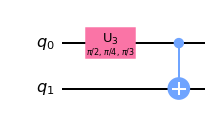

In [6]:
# 也可以画的更好看些
qiskit_qc.draw('mpl')

Circuit.random(gate_number) 用于生成一个随机的电路

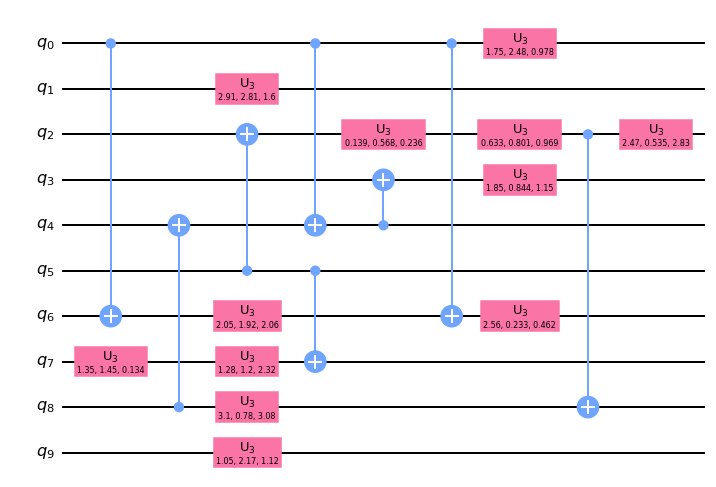

In [7]:
random_qubit_number = 10
random_qc = Circuit(random_qubit_number)
random_qc.random(20)
random_qc.toQiskit().draw('mpl')

## 得到电路所对应的矩阵

In [13]:
random_qc_matrix = random_qc.matrix()
random_qc_matrix

array([[ 5.27434499e-03+0.00890154j,  0.00000000e+00+0.j        ,
         7.85138376e-02-0.04365076j, ...,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
       [-1.14723900e-02-0.00451255j,  0.00000000e+00+0.j        ,
        -4.19017547e-02+0.09849011j, ...,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
       [-6.82438543e-02-0.05841736j,  0.00000000e+00+0.j        ,
         6.94199069e-03-0.00767234j, ...,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
       ...,
       [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        , ..., -1.52831705e-03-0.00049796j,
         0.00000000e+00+0.j        , -4.68646023e-03+0.01314518j],
       [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        , ...,  1.32552480e-02+0.010039j  ,
         0.00000000e+00+0.j        

In [14]:
random_qc_matrix.shape  # (2**qubit_number, 2**qubit_number)

(1024, 1024)

和开源库对比验证下

In [15]:
from qiskit.quantum_info import Operator
verified_qc = random_qc.toQiskit() # qiskt是小端, 我们这里是大端
verified_qc_matrix = Operator(verified_qc).data
print(np.allclose(random_qc_matrix, verified_qc_matrix))

True
